# Quarry Production and Downtime EDA

The following data is collected from a limestone quarry. We can assume that under ideal conditions, downtime is minimized and material is blasted, moved, processed, and shipped 24/7. The two provided data sets are the following:

(1) Daily Total Production (Tonnes)

(2) Downtime Events

In [44]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
# Load CSVs
dfprod = pd.read_csv("/Users/eliasforsberg/Documents/GitHub/quarry-eda/data/dfprod.csv")
dfdown = pd.read_csv("/Users/eliasforsberg/Documents/GitHub/quarry-eda/data/dfdown.csv")

### 1. Data Type Correction

First change production data types

In [46]:
dfprod.head()

,Date,Actual Tonnage
0,2024-01-01,0
1,2024-01-02,"6,267"
2,2024-01-03,"21,831"
3,2024-01-04,"17,462"
4,2024-01-05,"18,090"


In [47]:
dfprod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            329 non-null    object
 1   Actual Tonnage  329 non-null    object
dtypes: object(2)
memory usage: 5.3+ KB


In [48]:
# Convert features to useful data types
dfprod["Date"] = pd.to_datetime(dfprod["Date"])
dfprod["Actual Tonnage"] = dfprod["Actual Tonnage"].str.replace(',', '').astype(int)

Next, change downtime data types as required

In [49]:
dfdown.head()

,Date,Downtime Description,Start Time [24:00],End Time [24:00],Downtime Category,Duration (minutes),D_Change produced material,D_Electrical/Mechanical,D_Lack of feed,D_Meetings/Breaks/Training,D_Planned Maintenance,D_Production Stoppage,D_Rate loss,D_Start up/Shut Down,D_Weather/Environmental
0,2024-01-04,SAFETY TALK,2024-01-04 00:00:00,2024-01-04 00:15:00,Meetings/Breaks/Training,15,False,False,False,True,False,False,False,False,False
1,2024-01-04,CC AND TRAVEL,2024-01-04 00:15:00,2024-01-04 00:45:00,Start up/Shut Down,30,False,False,False,False,False,False,False,True,False
2,2024-01-04,LUNCH,2024-01-04 04:30:00,2024-01-04 05:15:00,Meetings/Breaks/Training,45,False,False,False,True,False,False,False,False,False
3,2024-01-04,SAFETY TALK,2024-01-04 08:00:00,2024-01-04 08:15:00,Meetings/Breaks/Training,15,False,False,False,True,False,False,False,False,False
4,2024-01-04,CC AND TRAVEL,2024-01-04 08:15:00,2024-01-04 08:30:00,Start up/Shut Down,15,False,False,False,False,False,False,False,True,False


In [50]:
dfdown.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Date                        5822 non-null   object
 1   Downtime Description        5822 non-null   object
 2   Start Time [24:00]          5811 non-null   object
 3   End Time [24:00]            5810 non-null   object
 4   Downtime Category           5817 non-null   object
 5   Duration (minutes)          5822 non-null   int64 
 6   D_Change produced material  5822 non-null   bool  
 7   D_Electrical/Mechanical     5822 non-null   bool  
 8   D_Lack of feed              5822 non-null   bool  
 9   D_Meetings/Breaks/Training  5822 non-null   bool  
 10  D_Planned Maintenance       5822 non-null   bool  
 11  D_Production Stoppage       5822 non-null   bool  
 12  D_Rate loss                 5822 non-null   bool  
 13  D_Start up/Shut Down        5822 non-null   bool

There appear to be a few null values as these are manually entered records.

In [51]:
# Convert features to useful data types
dfdown["Date"] = pd.to_datetime(dfdown["Date"])
dfdown["Start Time [24:00]"] = pd.to_datetime(dfdown["Start Time [24:00]"])
dfdown["End Time [24:00]"] = pd.to_datetime(dfdown["End Time [24:00]"])
dfdown["Duration (minutes)"] = dfdown["Duration (minutes)"].astype(int)

### 2. Initial Observations

Lets first take a look at the production dataframe. Descriptive information will give a useful overview.

In [52]:
dfprod.describe()

,Date,Actual Tonnage
count,329,329.000000
mean,2024-06-13 00:00:00,11035.188450
min,2024-01-01 00:00:00,0.000000
25%,2024-03-23 00:00:00,4843.000000
50%,2024-06-13 00:00:00,12322.000000
75%,2024-09-03 00:00:00,17481.000000
max,2024-11-24 00:00:00,23927.000000
std,NaN,7449.202362


In [53]:
print((dfprod["Actual Tonnage"] == 0).sum())

68


From the information above, we can see that there are no negative values (although there are a fair number of zeros). How does the production trend look?

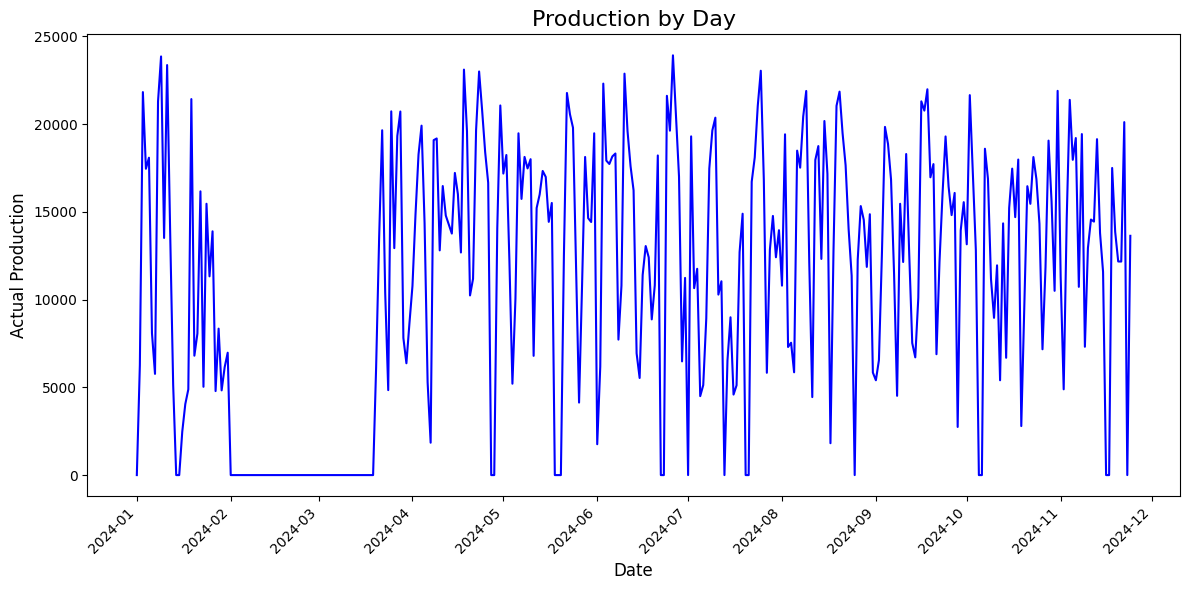

In [54]:
plt.figure(figsize=(12,6))
sns.lineplot(
    x="Date",
    y="Actual Tonnage",
    data=dfprod,
    color="blue"
)
plt.title("Production by Day", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Actual Production", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



As observed above, there is a large break during the winter shutdown then continued production throught the year. There are also a number of days where the plant appears to not be running (or is potentailly experiencing a downtime event).

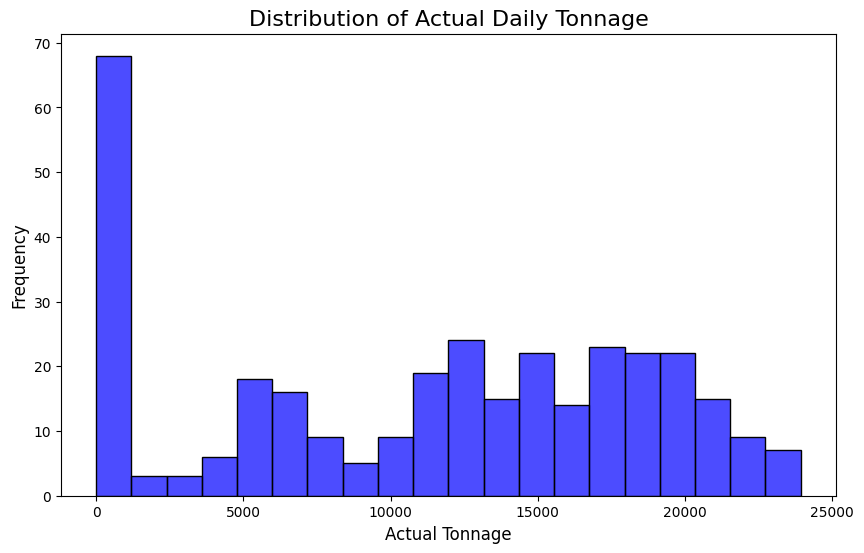

In [55]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(dfprod["Actual Tonnage"], bins=20, color="blue", alpha=0.7)
plt.title("Distribution of Actual Daily Tonnage", fontsize=16)
plt.xlabel("Actual Tonnage", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()


From the histogram, we see a large number of low (effectivly zero) production days and semi-uniform distribution (with lots of variance).

Let's now take a look at downtime.

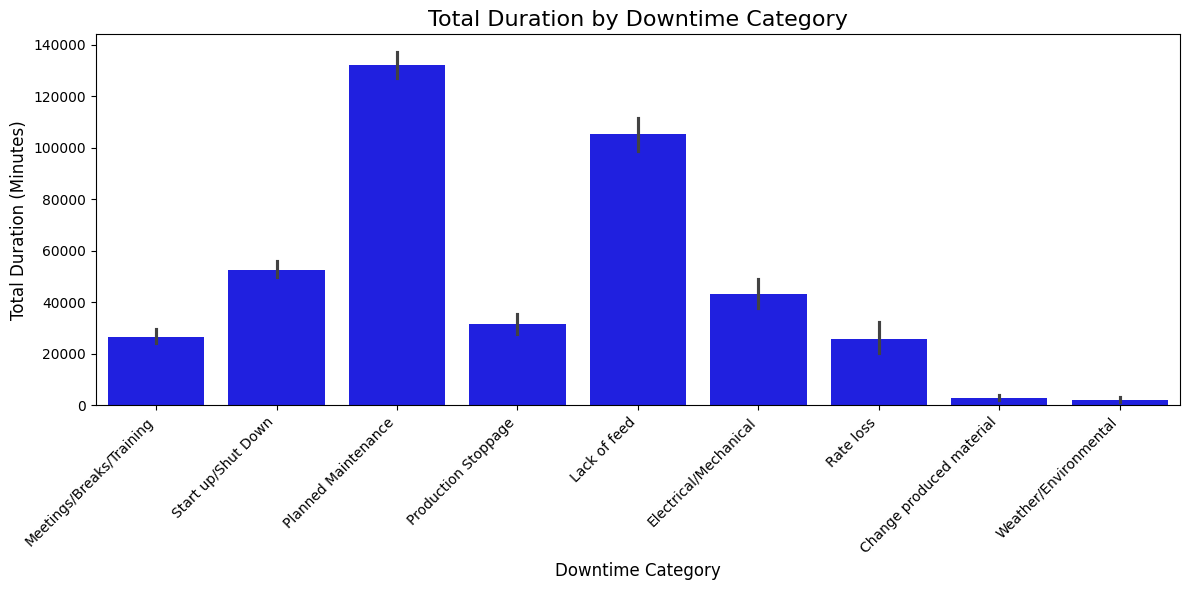

/var/folders/1z/jx78fd1109zcnx7s_1bnmx380000gn/T/ipykernel_73061/1051856799.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '151.31579800017536' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfdown_capped.loc[


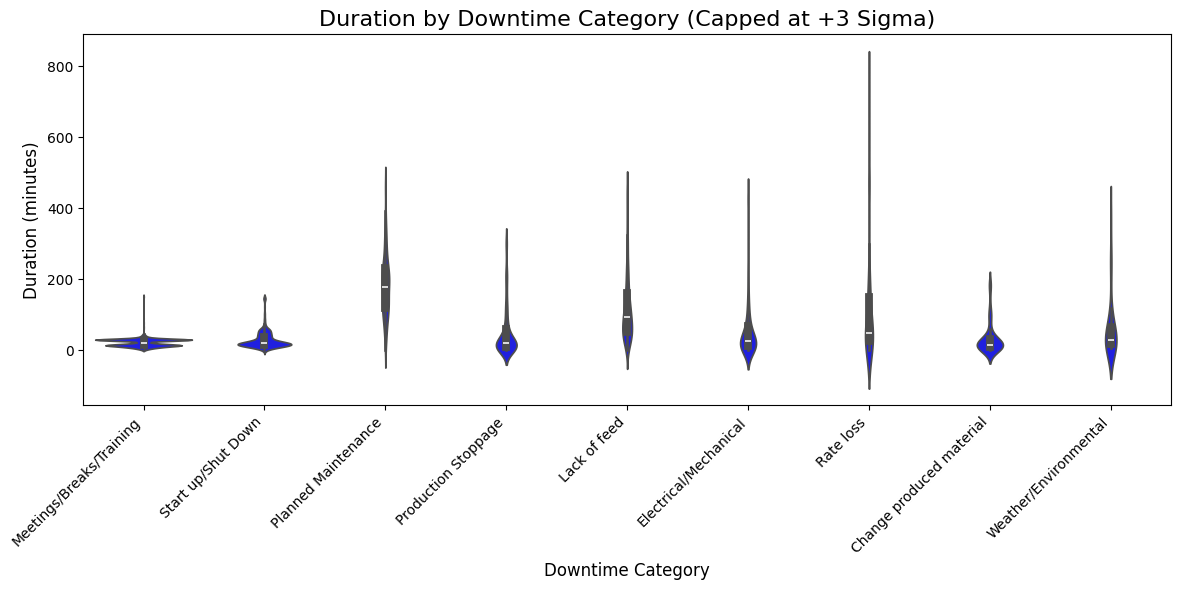

In [64]:
# Observing catagory sums

# Barplot of Downtime Category vs. Duration
plt.figure(figsize=(12, 6))
sns.barplot(
    x="Downtime Category", 
    y="Duration (minutes)", 
    data=dfdown, 
    estimator=sum,  # Summing durations for each category
    color="blue"
)
plt.title("Total Duration by Downtime Category", fontsize=16)
plt.xlabel("Downtime Category", fontsize=12)
plt.ylabel("Total Duration (Minutes)", fontsize=12)
plt.xticks(rotation=45, ha="right")  # Rotate category labels for better readability
plt.tight_layout()
plt.show()

"""Capping at +3 std dev for better interpretability"""

dfdown_capped = dfdown.copy()

# Calculate the mean and standard deviation for each category
for category in dfdown_capped["Downtime Category"].unique():
    category_data = dfdown_capped[dfdown_capped["Downtime Category"] == category]
    mean = category_data["Duration (minutes)"].mean()
    std = category_data["Duration (minutes)"].std()

    # Cap values exceeding +3 sigma
    upper_bound = mean + 3 * std
    dfdown_capped.loc[
        (dfdown_capped["Downtime Category"] == category) & 
        (dfdown_capped["Duration (minutes)"] > upper_bound), 
        "Duration (minutes)"
    ] = upper_bound

# Plotting
plt.figure(figsize=(12, 6))
sns.violinplot(
    x="Downtime Category", 
    y="Duration (minutes)", 
    data=dfdown_capped, 
    color="blue"
)
plt.title("Duration by Downtime Category (Capped at +3 Sigma)", fontsize=16)
plt.xlabel("Downtime Category", fontsize=12)
plt.ylabel("Duration (minutes)", fontsize=12)
plt.xticks(rotation=45, ha="right")  # Rotate category labels for better readability
plt.tight_layout()
plt.show()

Interestingly, we can observe that most of the lost downtime is from planned maintenance or lack of feed (no material coming into the processing plant due to some stoppage earlier in the process).

### 3. Cleaning

For prediction, lets remove the scheduled zero production days from our data set. We are only concerned with production figures when we plan on running the plant. We will remove all rows in dfprod where 'Actual Tonnage' == 0 and there are no listed downtime events (implying that the plant was not supposed to be running)

In [57]:
dfprod = dfprod[(dfprod["Actual Tonnage"] != 0) & (dfprod["Date"].isin(dfdown["Date"]))]

dfprod.describe()

,Date,Actual Tonnage
count,259,259.000000
mean,2024-07-03 10:33:49.343629312,13909.185328
min,2024-01-04 00:00:00,1759.000000
25%,2024-04-29 12:00:00,10443.500000
50%,2024-07-09 00:00:00,14449.000000
75%,2024-09-15 12:00:00,18150.000000
max,2024-11-24 00:00:00,23927.000000
std,NaN,5442.300395


Let's also make sure to remove any downtime events/days with missing values. We must be careful to distinguish between days where the plant was not running, and days that where planned to run but didn't due to a downtime event.

In [58]:
# Drop rows with NaN values in dfdown
dfdown_cleaned = dfdown.dropna()

# Identify the dates to exclude from dfprod
dates_to_exclude = dfdown[~dfdown.index.isin(dfdown_cleaned.index)]["Date"].unique()

# Remove rows in dfprod with matching dates
dfprod_cleaned = dfprod[~dfprod["Date"].isin(dates_to_exclude)]


In [59]:
print(dfprod.shape, dfprod_cleaned.shape)
print("")
print(dfdown.shape, dfdown_cleaned.shape)

(259, 2) (250, 2)

(5822, 15) (5805, 15)


In [60]:
print(dfprod_cleaned.isna().sum())
print("")
print(dfdown_cleaned.isna().sum())

Date              0
Actual Tonnage    0
dtype: int64

Date                          0
Downtime Description          0
Start Time [24:00]            0
End Time [24:00]              0
Downtime Category             0
Duration (minutes)            0
D_Change produced material    0
D_Electrical/Mechanical       0
D_Lack of feed                0
D_Meetings/Breaks/Training    0
D_Planned Maintenance         0
D_Production Stoppage         0
D_Rate loss                   0
D_Start up/Shut Down          0
D_Weather/Environmental       0
dtype: int64


As seen above, a number of rows have beeen removed with no null or NA values present.

In [61]:
dfprod_cleaned.describe()

,Date,Actual Tonnage
count,250,250.000000
mean,2024-07-08 18:25:55.200000,14105.688000
min,2024-01-04 00:00:00,1759.000000
25%,2024-05-06 06:00:00,10786.250000
50%,2024-07-14 12:00:00,14637.500000
75%,2024-09-17 18:00:00,18205.500000
max,2024-11-24 00:00:00,23927.000000
std,NaN,5358.394141


In [62]:
dfdown_cleaned.describe()

,Date,Start Time [24:00],End Time [24:00],Duration (minutes)
count,5805,5805,5805,5805.000000
mean,2024-07-09 00:50:36.279069952,2024-07-09 10:47:58.077519360,2024-07-09 12:00:40.754521856,72.711283
min,2024-01-04 00:00:00,2024-01-04 00:00:00,2024-01-04 00:15:00,0.000000
25%,2024-05-04 00:00:00,2024-05-04 07:30:00,2024-05-04 07:59:00,15.000000
50%,2024-07-15 00:00:00,2024-07-15 08:35:00,2024-07-15 08:53:00,30.000000
75%,2024-09-20 00:00:00,2024-09-20 12:24:00,2024-09-20 13:10:00,87.000000
max,2024-11-24 00:00:00,2024-11-24 13:17:00,2024-11-24 15:59:00,1439.000000
std,NaN,NaN,NaN,101.624430


We can also observe that there are no negative or absurdly high values. Now that we have some decent data, it's time to make some predictions!

### 4. Predicting Downtime Events